In [1]:
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

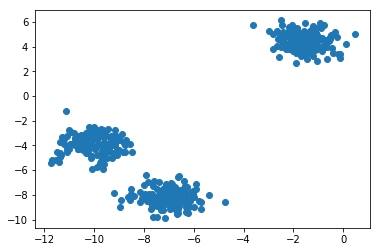

In [2]:
# create random distinct blobs of data

from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=500, centers=3, cluster_std=0.70, random_state=1, shuffle=True)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [3]:
# implement Gaussian Mixture Model

# initialize means, covariances, and mixing coefficients

def initialize(X, k):
    n, m = X.shape
    
    # use K-means to initialize the means
    kmeans = KMeans().fit(X)
    mu = kmeans.cluster_centers_
    sigma = np.array([np.eye(m)] * k)
    pi = np.ones(k)/k
    return mu, sigma, pi

# implement expectation-maximization algorithm

# compute responsibilities using initialized parameters
def e_step(mu, sigma, pi, k):
    n, m = X.shape
    gamma = np.zeros((k, n))
    
    for j in range(k):
        for i in range(n):
            gamma[j, i] = multivariate_normal(mu[j], sigma[j]).pdf(X[i]) * pi[j]
            
    gamma = gamma/gamma.sum(axis=0)
    return gamma

# re-estimate parameter values using responsibilities computed in e-step
def m_step(gamma, k):
    n, m = X.shape
    mu = np.zeros((k, m))
    sigma = np.zeros((k, m, m))
    pi = np.zeros(k)
    
    for j in range(k):
        
        for i in range(m):
            mu[j] += gamma[j, i] * X[i]
            
        mu[j] = mu[j]/gamma[j, :].sum()    
    
        for i in range(n):
            ys = np.reshape(X[i]- mu[j], (m, 1))
            sigma[j] += gamma[j, i] * np.dot(ys, ys.T)
            pi[j] += gamma[j, i]
            
        sigma[j] = sigma[j]/gamma[j,:].sum()
        
    pi = pi/n
        
    return mu, sigma, pi

def my_gmm(X, k, max_iter, threshold):
    n, m = X.shape
    mu, sigma, pi = initialize(X, k)
    
    old_logl = 0
    
    # loop through iterations
    for i in range(max_iter):
        
        gamma = e_step(mu, sigma, pi, k)
        mu, sigma, pi = m_step(gamma, k)
        
        new_logl = 0
        
        # compute log likelihoods
        for i in range(n):
            temp = 0
            for j in range(k):
                temp += pi[j] * multivariate_normal(mu[j], sigma[j]).pdf(X[i])
            new_logl += np.log(temp)
            
        # stopping criterion for log likelihood convergence
        if np.abs(new_logl - old_logl) < threshold:
            break
            
        old_logl = new_logl
        
    return mu, sigma, pi, gamma

# partial source: https://github.com/Monisha-Balaji/Data-Mining-Clustering-Algorithms/blob/master/project2_Clustering/Codes/GMM.py
# full reference in bibliography

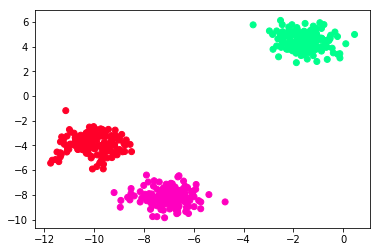

In [4]:
# fit my model to data and visualize clusters formed

mu, sigma, pi, gamma = my_gmm(X, 3, 100, 0.001)
labels = gamma.argmax(axis=0)
plt.scatter(X[:,0], X[:,1], c=labels, cmap='gist_rainbow')
plt.show()

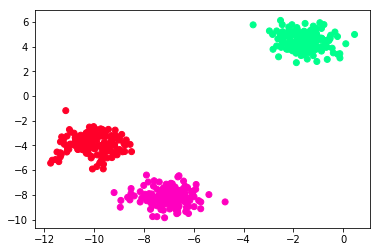

In [5]:
# apply scikit-learn GMM to data for comparison

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=1)
gmm.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, cmap='gist_rainbow')
plt.show()

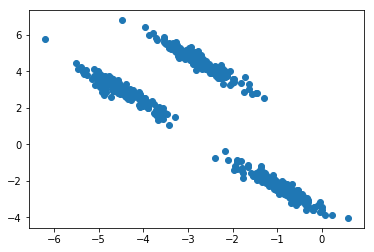

In [6]:
# create stretched blobs of data

transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_transformed = np.dot(X, transformation)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

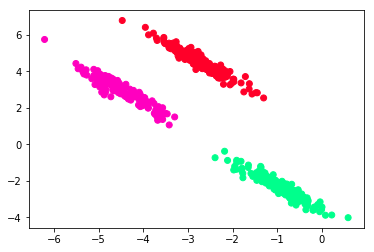

In [7]:
# fit my model to data and visualize clusters formed

mu, sigma, pi, gamma = my_gmm(X_transformed, 3, 100, 0.001)
labels = gamma.argmax(axis=0)
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=labels, cmap='gist_rainbow')
plt.show()

As seen from the visualizations, my GMM model accurately clusters both datasets. GMM can accurately cluster data in non-distinct shapes like the stretched blobs shown above, unlike other common clustering algorithms like K-means and hierarchical agglomerative clustering.